<a href="https://colab.research.google.com/github/ibrahimba9/New_York_Taxi_Trips/blob/main/NY_Taxi_Fare_Prediction_PySpark_Google_Colab_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# got to kaggele > profile > account > scroll down > click exprire api token > click on create new api token

In [29]:
! pip install -q kaggle

In [33]:
from google.colab import files

In [36]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ibrahimbenabdallah","key":"634fe495234e4524eb0d822988e03dd5"}'}

In [37]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [38]:
!cp kaggle.json ~/.kaggle/

In [40]:
!chmod 600 ~/.kaggle/kaggle.json

In [41]:
!kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              227KB  2021-05-08 09:30:51           4790  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           2752  
mathurinache/twitter-edge-nodes                             Twitter Edge Nodes                                342MB  2021-03-08 06:43:04            305  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Job Listing 2020                     42MB  2021-03-05 06:59:52            677  
dhruvildave/wikibooks-dataset                               Wikibooks Datase

In [219]:
! kaggle competitions download -c 'new-york-city-taxi-trips-2019'

404 - Not Found


In [43]:
! mkdir taxi_data

In [46]:
!unzip train.csv.zip -d taxi_data

Archive:  train.csv.zip
  inflating: taxi_data/train.csv     


In [47]:
!mv test.csv taxi_data

In [48]:
!ls

 GCP-Coupons-Instructions.rtf   sample_submission.csv		  taxi_data
'kaggle (1).json'	        spark-2.4.5-bin-hadoop2.7	  train.csv.zip
 kaggle.json		        spark-2.4.5-bin-hadoop2.7.tgz
 sample_data		        spark-2.4.5-bin-hadoop2.7.tgz.1


In [1]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

!pip install -U pyarrow

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [2,150 kB]
Hit:12 http://ppa.launchpad.net/cra

In [293]:
import findspark
from pyspark.sql import SparkSession
import sys,tempfile
import urllib.request
from pyspark.sql.types import LongType, StringType, StructField, StructType, BooleanType, ArrayType, IntegerType, DoubleType, TimestampType, FloatType
from pyspark.sql.functions import udf, radians, sqrt, sin, asin, cos, acos, col, array
import pandas as pd
import numpy as np

In [7]:
findspark.init()
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.executor.memory", "4g")
spark.conf.set("spark.driver.memory", "4g")
spark.conf.set("spark.memory.fraction", "0.9")


In [269]:
df = spark.read.option("inferSchema", "false").csv("taxi_data/train.csv", header=True)
df.printSchema()

root
 |-- key: string (nullable = true)
 |-- fare_amount: string (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- pickup_longitude: string (nullable = true)
 |-- pickup_latitude: string (nullable = true)
 |-- dropoff_longitude: string (nullable = true)
 |-- dropoff_latitude: string (nullable = true)
 |-- passenger_count: string (nullable = true)



In [270]:
df.show()

+--------------------+-----------+--------------------+----------------+---------------+-----------------+----------------+---------------+
|                 key|fare_amount|     pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|
+--------------------+-----------+--------------------+----------------+---------------+-----------------+----------------+---------------+
|2009-06-15 17:26:...|        4.5|2009-06-15 17:26:...|      -73.844311|      40.721319|        -73.84161|       40.712278|              1|
|2010-01-05 16:52:...|       16.9|2010-01-05 16:52:...|      -74.016048|      40.711303|       -73.979268|       40.782004|              1|
|2011-08-18 00:35:...|        5.7|2011-08-18 00:35:...|      -73.982738|       40.76127|       -73.991242|       40.750562|              2|
|2012-04-21 04:30:...|        7.7|2012-04-21 04:30:...|       -73.98713|      40.733143|       -73.991567|       40.758092|              1|
|2010-03-09 07:51:..

In [271]:
schema = StructType([
          StructField("key", TimestampType(), True),
          StructField("fare_amount", DoubleType(), True),
          StructField("pickup_datetime", TimestampType(), True),
          StructField("pickup_longitude", DoubleType(), True),
          StructField("pickup_latitude", DoubleType(), True),
          StructField("dropoff_longitude", DoubleType(), True),
          StructField("dropoff_latitude", DoubleType(), True),
          StructField("passenger_count", IntegerType(), True)
])
          

print(schema)

df = spark.read.csv("taxi_data/train.csv", header=True, schema=schema, enforceSchema=True, timestampFormat="yyyy-MM-dd HH:mm:ss")

StructType(List(StructField(key,TimestampType,true),StructField(fare_amount,DoubleType,true),StructField(pickup_datetime,TimestampType,true),StructField(pickup_longitude,DoubleType,true),StructField(pickup_latitude,DoubleType,true),StructField(dropoff_longitude,DoubleType,true),StructField(dropoff_latitude,DoubleType,true),StructField(passenger_count,IntegerType,true)))


In [272]:
df.printSchema()

root
 |-- key: timestamp (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- passenger_count: integer (nullable = true)



In [273]:
df.show()

+-------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+
|                key|fare_amount|    pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|
+-------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+
|2009-06-15 17:26:21|        4.5|2009-06-15 17:26:21|      -73.844311|      40.721319|        -73.84161|       40.712278|              1|
|2010-01-05 16:52:16|       16.9|2010-01-05 16:52:16|      -74.016048|      40.711303|       -73.979268|       40.782004|              1|
|2011-08-18 00:35:00|        5.7|2011-08-18 00:35:00|      -73.982738|       40.76127|       -73.991242|       40.750562|              2|
|2012-04-21 04:30:42|        7.7|2012-04-21 04:30:42|       -73.98713|      40.733143|       -73.991567|       40.758092|              1|
|2010-03-09 07:51:00|        5.3|2

In [200]:
df.count()

55423856

In [274]:
df.createOrReplaceTempView('ny_taxi')

In [204]:
spark.sql("select distinct(passenger_count) from ny_taxi").show()

+---------------+
|passenger_count|
+---------------+
|             34|
|              1|
|              6|
|              3|
|              5|
|              9|
|              4|
|              8|
|             49|
|              7|
|             51|
|            129|
|              2|
|              0|
|            208|
+---------------+



In [207]:
spark.sql("select passenger_count, count(*) from ny_taxi group by passenger_count order by passenger_count").show()

+---------------+--------+
|passenger_count|count(1)|
+---------------+--------+
|              0|  195416|
|              1|38337524|
|              2| 8175243|
|              3| 2432712|
|              4| 1178852|
|              5| 3929346|
|              6| 1174647|
|              7|      15|
|              8|       9|
|              9|      23|
|             34|       1|
|             49|       1|
|             51|       1|
|            129|       2|
|            208|      64|
+---------------+--------+



In [210]:
spark.sql("select min(year(pickup_datetime)) from ny_taxi").show()

+----------------------------------------+
|min(year(CAST(pickup_datetime AS DATE)))|
+----------------------------------------+
|                                    2009|
+----------------------------------------+



In [212]:
spark.sql("select max(year(pickup_datetime)) from ny_taxi").show()

+----------------------------------------+
|max(year(CAST(pickup_datetime AS DATE)))|
+----------------------------------------+
|                                    2015|
+----------------------------------------+



In [224]:
sample  = df.sample(withReplacement=False, fraction=0.0001, seed=1)

In [225]:
sample = sample.toPandas()

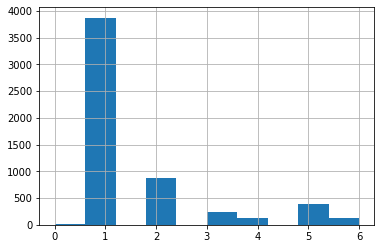

In [226]:
sample["passenger_count"].hist()

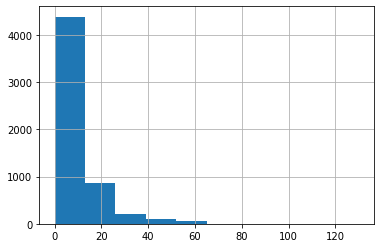

In [227]:
sample["fare_amount"].hist()

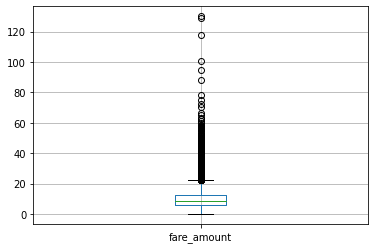

In [229]:
sample.boxplot("fare_amount")

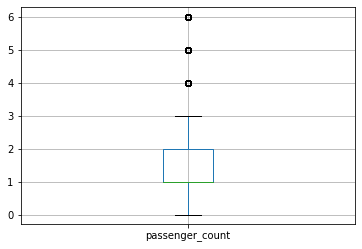

In [230]:
sample.boxplot("passenger_count")

# Feature extraction
- Havershine Distance
- Manhattan Distance
- Bearing between 2 long/latt
- Center Lattitude and Longitude between Pickup and dropoff


In [336]:
def havershine_distance(lat1, lng1, lat2, lng2):
  """
  Description:
    Calculated the Havershine Distance between 2 points on a sphere given their longitudes and lattitudes.
  Inputs:
    - lng1: longitude of the first point
    - lat1: latitude of the first point
    - lng2: longitude of the second point
    - lat2: latitude of the second point
  Output:
    - distance: FLoat
  """
  from math import radians, cos, sin, asin, sqrt
  lat1, lng1, lat2, lng2 = map(radians, [lat1, lng1, lat2, lng2])
  AVG_EARTH_RADIUS = 6371
  lat = lat1 - lat2
  lng = lng1 - lng2
  d = sin(lat * 5) ** 2 + cos(lat1) * cos(lat2) * sin(lng* 0.5) ** 2
  return 2 * AVG_EARTH_RADIUS * asin(sqrt(d))


In [337]:
udf_havershine_distance = F.udf(havershine_distance, DoubleType())
df2 = df.withColumn("havershine_distance", udf_havershine_distance("pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"))

In [338]:
df2.show()

+-------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+-------------------+
|                key|fare_amount|    pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|havershine_distance|
+-------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+-------------------+
|2009-06-15 17:26:21|        4.5|2009-06-15 17:26:21|      -73.844311|      40.721319|        -73.84161|       40.712278|              1|   10.0557102645355|
|2010-01-05 16:52:16|       16.9|2010-01-05 16:52:16|      -74.016048|      40.711303|       -73.979268|       40.782004|              1|  78.67696002955688|
|2011-08-18 00:35:00|        5.7|2011-08-18 00:35:00|      -73.982738|       40.76127|       -73.991242|       40.750562|              2| 11.928278751451886|
|2012-04-21 04:30:42|        7.7|2012-04-21 04:30:42

In [252]:
def manhattan_distance(lat1, lon1, lat2, lon2):
  """
  Description:
    Calculated the Havershine Distance between 2 points on a sphere given their longitudes and lattitudes.
  Inputs:
    - lng1: longitude of the first point
    - lat1: latitude of the first point
    - lng2: longitude of the second point
    - lat2: latitude of the second point
  Output:
    - distance: FLoat
  """
  # Pickup coordinates
  p = np.stack([lat1, lon1], axis = 1)

  # Dropoff coordinates
  d = np.stack([lat2, lon2], axis = 1)

  theta1 = np.radians(-28.904)
  theta2 = np.radians(28.904)

  ## Rotation matrix
  R1 = np.array([[np.cos(theta1), np.sin(theta1)], 
                  [-np.sin(theta1), np.cos(theta1)]]
                )
  R2 = np.array([[np.cos(theta2), np.sin(theta2)], 
                  [-np.sin(theta2), np.cos(theta2)]]
                )

  # Rotate Pickup and Dropoff coordinates by -29 degress in World2
  pT = R1 @ p.T  
  dT = R1 @ d.T  

  # Coordinates of Hinge point in the rotated world 
  vT = np.stack((pT[0,:], dT[1,:]))
  # Coordinates of Hinge point in the real world 
  v = R2 @ vT
  """ Finally,

  Manhattan distance 
          = 
  Haversine dist between Pickup & Hingept
          +
  Haversine dist between Hinge pt & Dropoff location 
  """

  return (havershine_distance(p.T[0], p.T[1], v[0], v[1]) + 
          havershine_distance(v[0], v[1], d.T[0], d.T[1])
          )

In [253]:
udf_manhatnna_distance = F.udf(manhattan_distance, DoubleType())
df = df.withColumn("manhattan_distance", udf_manhatnna_distance(df["pickup_latitude"], df["pickup_longitude"], df["dropoff_latitude"], df["dropoff_longitude"]))

In [254]:
def bearing_array(lat1, lng1, lat2, lng2): 
  """
  Description:
    Calculated the Bearing between 2 points on a sphere given their longitudes and lattitudes.
  Inputs:
    - lng1: longitude of the first point
    - lat1: latitude of the first point
    - lng2: longitude of the second point
    - lat2: latitude of the second point
  Output:
    - distance: FLoat
  """
  AVG_EARTH_RADIUS = 6371 # in km 
  lng_delta_rad = np.radians(lng2 - lng1) 
  lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2)) 
  y = np.sin(lng_delta_rad) * np.cos(lat2) 
  x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad) 
  return np.degrees(np.arctan2(y, x))

In [255]:
udf_bearing = F.udf(bearing_array, DoubleType())
df = df.withColumn("bearing", udf_bearing(df["pickup_latitude"], df["pickup_longitude"], df["dropoff_latitude"], df["dropoff_longitude"]))

In [256]:
df.createOrReplaceTempView('ny_taxi')

In [257]:
df.show()

Py4JJavaError: ignored